In [1]:
import numpy as np
import pandas as pd
import os
import nibabel as nb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn



In [2]:
brain = nb.load('/Users/benparker/Desktop/cnl/subjects/100307/mri/orig.mgz')

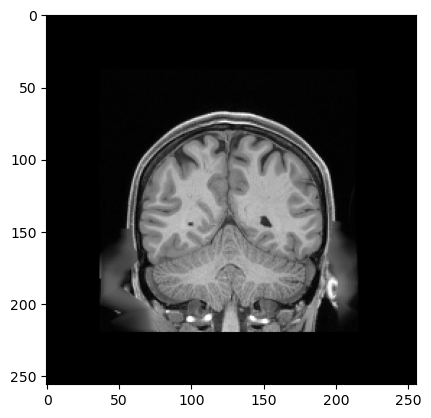

In [3]:
bdata = brain.get_fdata()
plt.imshow(bdata[:,:,100].T, cmap='gray')

In [4]:
annot = nb.load('/Users/benparker/Desktop/cnl/subjects/100307/mri/lh.test_annot.nii.gz')
annot = annot.get_fdata()

In [5]:
np.unique(annot)

array([0., 1., 2., 3., 4.])

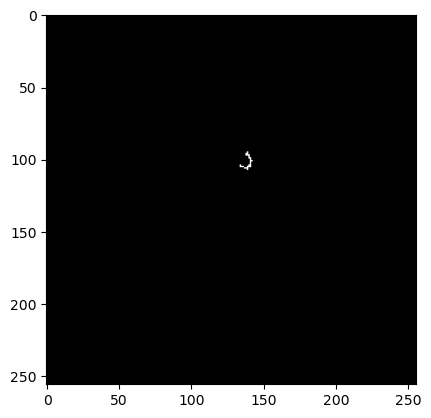

In [6]:
plt.imshow(annot[:,:,100].T, cmap='gray')

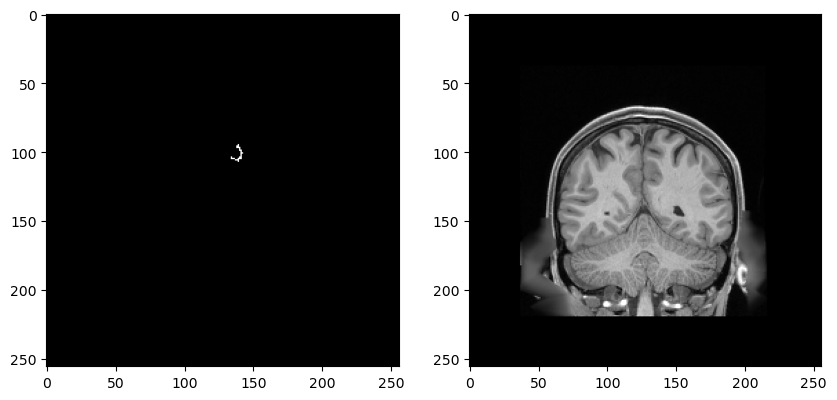

In [7]:
stacked = np.stack([bdata, annot])
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(stacked[1,:,:,100].T, cmap='gray');
ax[1].imshow(stacked[0,:,:,100].T, cmap='gray');

Import annotation mask and stack on the brain volume. 

## Models

In [24]:


class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )
        
        self.encoder4 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv3d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm3d(1024),
            nn.ReLU(inplace=True),
            nn.Conv3d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm3d(1024),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=2),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True)
        )
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, out_channels, kernel_size=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x = self.encoder1(x)
        x = nn.MaxPool3d(2)(x)
        
        x = self.encoder2(x)
        x = nn.MaxPool3d(2)(x)
        
        x = self.encoder3(x)
        x = nn.MaxPool3d(2)(x)
        
        x = self.encoder4(x)
        x = nn.MaxPool3d(2)(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        x = self.decoder4(x)
        x = self.decoder3(x)
        x = self.decoder2(x)
        x = self.decoder1(x)
        
        return x
    
model = UNet3D(2, 2) 
